In [1]:
#import pandas as pd

#df = pd.read_csv('https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/bank-full.csv', delimiter=';')

In [3]:
import pandas as pd

df = pd.read_csv('/content/bank-full.csv', sep=';')

# Muestra las primeras filas del DataFrame para verificar que se cargó correctamente
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
# Assuming 'y' is a column in your DataFrame 'df' that you want to convert.
df['y'] = df['y'].map({'yes': 1, 'no': 0})

print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0  


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

**Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.

Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

balance
day
duration
previous

In [8]:

from sklearn.metrics import roc_auc_score

numerical_features = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for feature in numerical_features:
    auc = roc_auc_score(df_train['y'], df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[feature])
        auc_scores[feature] = auc
    else:
      auc_scores[feature] = auc

max_auc_feature = max(auc_scores, key=auc_scores.get)

print(auc_scores)
print(f"The numerical variable with the highest AUC is: {max_auc_feature}")

{'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'previous': 0.5985653242764153}
The numerical variable with the highest AUC is: duration


**Question 2: Training the model**

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

0.69

0.79

0.89

0.99

In [9]:


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Prepare the data for one-hot encoding
train_dicts = df_train.drop('y', axis=1).to_dict(orient='records')
val_dicts = df_val.drop('y', axis=1).to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train['y']
y_val = df_val['y']

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred)

print(f"AUC on the validation dataset: {auc:.3f}")

AUC on the validation dataset: 0.901


**Question 3: Precision and Recall**

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them

At which threshold precision and recall curves intersect?

0.265

0.465

0.665

0.865

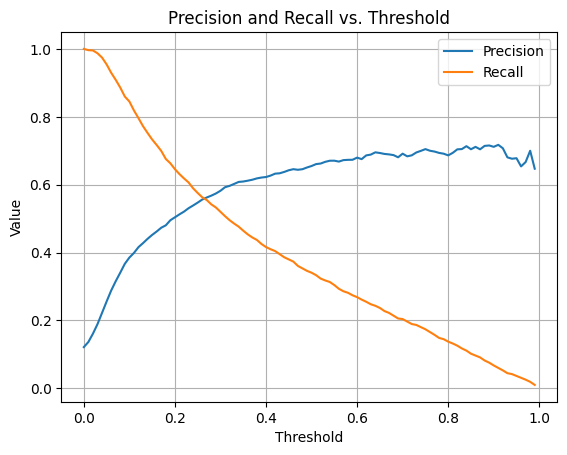

Intersection point approximately at threshold: 0.260


In [10]:
# prompt: Now let's compute precision and recall for our model.
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01 For each threshold, compute precision and recall Plot them with division lines each 0.01
# At which threshold precision and recall curves intersect?

import matplotlib.pyplot as plt

def calculate_precision_recall(y_true, y_pred_proba, threshold):
  y_pred = (y_pred_proba >= threshold).astype(int)
  tp = ((y_true == 1) & (y_pred == 1)).sum()
  fp = ((y_true == 0) & (y_pred == 1)).sum()
  fn = ((y_true == 1) & (y_pred == 0)).sum()

  if tp == 0:
    precision = 0
    recall = 0
  else:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

  return precision, recall

thresholds = [i/100 for i in range(0, 100)]
precisions = []
recalls = []

for threshold in thresholds:
  precision, recall = calculate_precision_recall(y_val, y_pred, threshold)
  precisions.append(precision)
  recalls.append(recall)


# Find the intersection point
intersection_threshold = None
for i in range(len(thresholds)):
  if abs(precisions[i] - recalls[i]) < 0.01:
    intersection_threshold = thresholds[i]
    break


plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


print(f"Intersection point approximately at threshold: {intersection_threshold:.3f}")

**Question 4:**
F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
F1 = (2*P*R)/(P+R)

Where
P
 is precision and
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.02
0.22
0.42
0.62


In [ ]:
print(precisions)
print(recalls)

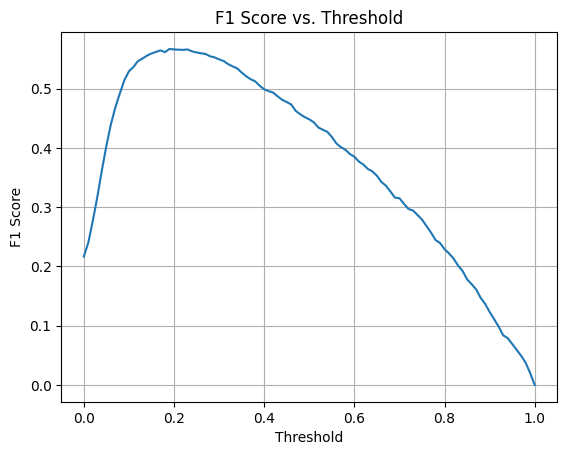

The maximal F1 score is: 0.567
The threshold at which F1 is maximal is: 0.19


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming you have the 'bank-full.csv' file in the same directory
df = pd.read_csv('bank-full.csv', sep=';')

# Map 'y' to numerical values
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# ... (Previous code for AUC and training the model) ...

def calculate_precision_recall(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()

    if tp == 0:
        precision = 0
        recall = 0
    else:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

    return precision, recall

thresholds = [i / 100 for i in range(0, 101)]
f1_scores = []

for threshold in thresholds:
    precision, recall = calculate_precision_recall(y_val, y_pred, threshold)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    f1_scores.append(f1)

# Find the threshold with the maximal F1 score
max_f1_score = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1_score)]

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

print(f"The maximal F1 score is: {max_f1_score:.3f}")
print(f"The threshold at which F1 is maximal is: {max_f1_threshold:.2f}")

**Question 5: 5-Fold CV**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train
Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.26

In [14]:
import numpy as np
from sklearn.model_selection import KFold

# ... (Previous code for data preparation and model training) ...

n_splits = 5
scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    train_dicts = df_train.drop('y', axis=1).to_dict(orient='records')
    val_dicts = df_val.drop('y', axis=1).to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    y_train = df_train['y']
    y_val = df_val['y']

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

std_dev = np.std(scores)
print(f"Standard deviation of AUC scores across folds: {std_dev:.3f}")

Standard deviation of AUC scores across folds: 0.005


**Question 6:**

Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]

Initialize KFold with the same parameters as previously

Use these parameters for the model:

LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001

0.001

1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [15]:
n_splits = 5
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
  scores = []
  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

  for train_idx, val_idx in kfold.split(df_full_train):
      df_train = df_full_train.iloc[train_idx]
      df_val = df_full_train.iloc[val_idx]

      train_dicts = df_train.drop('y', axis=1).to_dict(orient='records')
      val_dicts = df_val.drop('y', axis=1).to_dict(orient='records')

      dv = DictVectorizer(sparse=False)
      X_train = dv.fit_transform(train_dicts)
      X_val = dv.transform(val_dicts)

      y_train = df_train['y']
      y_val = df_val['y']

      model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
      model.fit(X_train, y_train)

      y_pred = model.predict_proba(X_val)[:, 1]
      auc = roc_auc_score(y_val, y_pred)
      scores.append(auc)

  mean_score = np.mean(scores)
  std_score = np.std(scores)
  results[C] = (mean_score, std_score)

# Find the best C based on mean score and standard deviation
best_C = None
best_mean_score = -1
lowest_std = float('inf')

for C, (mean_score, std_score) in results.items():
    if mean_score > best_mean_score:
        best_mean_score = mean_score
        best_C = C
        lowest_std = std_score
    elif mean_score == best_mean_score and std_score < lowest_std:
        best_C = C
        lowest_std = std_score

print(f"Results: {results}")
print(f"The best C is: {best_C}")


Results: {1e-06: (0.7015756963414919, 0.009451497869297436), 0.001: (0.865462383964769, 0.007275365601673848), 1: (0.9068616933183498, 0.005398443893771979)}
The best C is: 1
